### Developing the DataGenerator

In [142]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

# Inspired by https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    '''Generates .npy files for Conv2D'''
    def __init__(self, data_dir, include=None, batch_size=32, 
                 dim=(128,640), n_channels=1, test=False):
        '''
        Parameters
        ----------
        data_dir : str
            Path to data split (training, validation, or test)
        include : list or None
            Subdirectories to include
            if None, include all
        batch_size : int
            Number of files to return at a time
            Auto set to 1 if test=True
        dim : tuple
            Dimension of arrays to read in
        n_channels : int
            Number of color channels for image array
        test : bool
            If test split, store labels, do not shuffle indices,
            and set batch_size to 1
        '''
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.test = test
        self.include = include
        self.test_labels = None
        
        self.label_dict = self.__get_label_dict()
        self.files = self.__get_files()
        self.n_classes = len(self.label_dict)   # Number of sub dirs
        self.on_epoch_end()                    # populates self.indexes
        if self.test:
            self.test_labels = np.empty((len(self.files), self.n_classes), dtype=int)
            self.batch_size = 1
            
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        idxs = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

        # Find list of IDs
        file_list = self.files[idxs]

        # Generate data
        X, y = self.__data_generation(file_list)
        
        if self.test:
            self.test_labels[idxs,] = y

        return X, y

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.files))
        if not self.test:
            np.random.shuffle(self.indexes) # Shuffles in place
            
    def __get_files(self):
        '''Get all files from subdirectories of data_dir'''
        subdirs = [k for k in self.label_dict.keys()]
        all_files = []

        for subdir in subdirs:
            full_dir = os.path.join(self.data_dir, subdir)
            files = os.listdir(full_dir)
            for file in files:
                all_files.append(os.path.join(subdir, file))

        return np.array(all_files)

    def __get_label_dict(self):
        '''
        Create dict of labels from sub directories
        {Genre : int}
        '''
        subdirs = sorted(os.listdir(self.data_dir))
        
        # Only include specific sub dirs
        if self.include:
            subdirs = [s for s in subdirs if s in self.include]
        
        labels = np.arange(len(subdirs))
        return {k:v for k,v in zip(subdirs, labels)}
    
    def __data_generation(self, file_list):
        '''
        Generates data containing batch_size samples
        
        Parameters
        ----------
        file_list : list or np.array
            List of files to retrieve/process/load
        
        Returns
        -------
        X : (n_samples, *dim, n_channels)
        
        '''  
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, file in enumerate(file_list):
            npy = np.load(os.path.join(self.data_dir, file))
            target = file.split('/')[0]
            label = self.label_dict[target]
            X[i,] = npy[:,:,None]   # Create extra dim for channel
            y[i,] = label

        return X, to_categorical(y, num_classes=self.n_classes, dtype='int')

In [86]:
include=['Rock', 'Hip-Hop']
sortd=['Rock', 'Hip-Hop', 'Instrumental']

subdirs = [subdir for subdir in sortd if subdir in include]
subdirs

['Rock', 'Hip-Hop']

In [87]:
datagen = DataGenerator('../data/training', include=['Rock', 'Hip-Hop'], batch_size=64, dim=(128,640), 
                        n_channels=1, test=False)

In [88]:
len(datagen)

24

In [89]:
i = datagen.__getitem__(1)

In [90]:
i[0].shape

(64, 128, 640, 1)

In [91]:
i[0].shape == (64, 128, 640, 1)

True

In [92]:
i[1][:4]

array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1]])

In [93]:
datagen.label_dict

{'Hip-Hop': 0, 'Rock': 1}

In [41]:
valid_datagen = DataGenerator('../data/validation', batch_size=64, dim=(128,640), 
                              n_channels=1, test=False)

In [42]:
len(valid_datagen)

4

## Test DataGenerator on model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D, Flatten, Conv1D, \
                                    Conv2D, BatchNormalization, MaxPooling1D, \
                                    GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, ELU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers

In [49]:
# Build model
model = Sequential()

model.add(Conv2D(32, (9, 9), input_shape = (128, 640, 1), 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units = 3, activation = 'softmax'))

opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 640, 32)      2624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 320, 32)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 320, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 316, 64)       51264     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 314, 128)      73856     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)              

In [51]:
checkpoint_callback = ModelCheckpoint('../models/model2_with_datagen_best_val_loss.h5', 
                                      monitor='val_loss', mode='min',
                                      save_best_only=True, verbose=1)

reducelr_callback = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.8, 
                                      patience=2, min_delta=0.005, verbose=1)

callbacks_list = [checkpoint_callback, reducelr_callback]

In [52]:
history = model.fit_generator(generator=datagen, epochs=25,
                              validation_data=valid_datagen, verbose=1, 
                              callbacks=callbacks_list)

Epoch 1/25
36/37 [============================>.] - ETA: 0s - loss: 1.0923 - accuracy: 0.3559
Epoch 00001: val_loss improved from inf to 1.08663, saving model to ../models/model2_with_datagen_best_val_loss.h5
37/37 [==============================] - 25s 683ms/step - loss: 1.0915 - accuracy: 0.3632 - val_loss: 1.0866 - val_accuracy: 0.3320
Epoch 2/25
36/37 [============================>.] - ETA: 0s - loss: 1.0012 - accuracy: 0.4852
Epoch 00002: val_loss improved from 1.08663 to 1.04347, saving model to ../models/model2_with_datagen_best_val_loss.h5
37/37 [==============================] - 23s 613ms/step - loss: 1.0032 - accuracy: 0.4840 - val_loss: 1.0435 - val_accuracy: 0.4375
Epoch 3/25
36/37 [============================>.] - ETA: 0s - loss: 0.9350 - accuracy: 0.5482
Epoch 00003: val_loss did not improve from 1.04347
37/37 [==============================] - 23s 612ms/step - loss: 0.9332 - accuracy: 0.5498 - val_loss: 1.1459 - val_accuracy: 0.3906
Epoch 4/25
36/37 [===================

In [79]:
history.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 640, 32)      2624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 320, 32)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64, 320, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 60, 316, 64)       51264     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 58, 314, 128)      73856     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 128)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)              

NoneType

In [98]:
import matplotlib.pyplot as plt

def show_summary_stats(history, savepath=None, dpi=100):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.figure(figsize=(4,3), dpi=dpi)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    if savepath:
        plt.savefig(os.path.join(savepath, f''), 
                    dpi=dpi)
    plt.show()

    # Summarize history for loss
    plt.figure(figsize=(4,3), dpi=dpi)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    if savepath:
        plt.savefig(savepath, dpi=dpi)
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


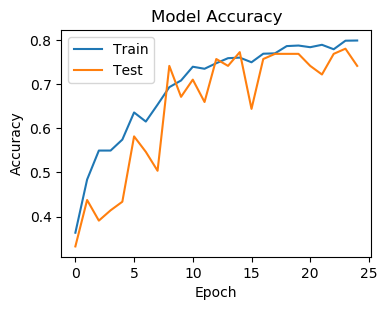

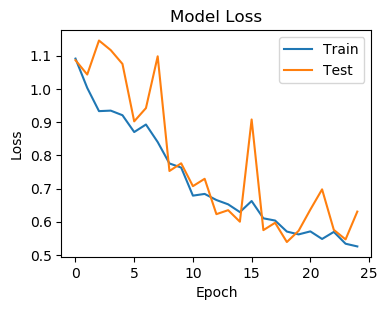

In [99]:
show_summary_stats(history)

In [143]:
test_datagen = DataGenerator('../data/test', batch_size=64, dim=(128,640), 
                              n_channels=1, test=True)

In [144]:
y_pred = model.predict_generator(test_datagen)
y_pred = np.argmax(y_pred, axis=1)
y_pred


array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2])

In [147]:
y_true = test_datagen.test_labels
y_true = np.argmax(y_true, axis=1)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [149]:
target_names = sorted(test_datagen.label_dict.keys())

In [150]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=target_names))

(300,) (300,)
              precision    recall  f1-score   support

     Hip-Hop       0.87      0.88      0.88       100
Instrumental       0.86      0.78      0.82       100
        Rock       0.80      0.86      0.83       100

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



In [151]:
model.evaluate_generator(generator=test_datagen)

[0.4093598937491576, 0.84]

In [168]:
from sklearn.metrics import confusion_matrix
from matplotlib import cm
import seaborn as sns

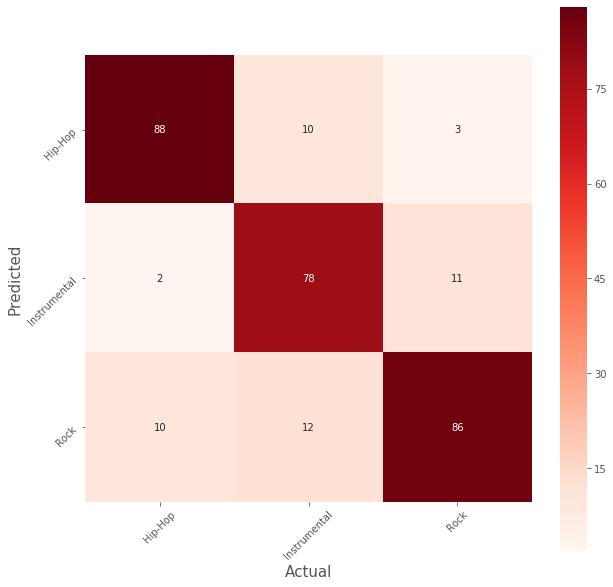

In [172]:
mat = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', 
            cbar=True, cmap=cm.Reds,
            xticklabels=target_names,
            yticklabels=target_names,
            ax=ax)

plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.xlabel('Actual', size=15)
plt.ylabel('Predicted', size=15);

## Scrap

In [121]:
subdirs = sorted(os.listdir(filepath))
labels = np.arange(len(subdirs))

In [124]:
{k:v for k,v in zip(subdirs, labels)}

{'Hip-Hop': 0, 'Instrumental': 1, 'Rock': 2}

In [72]:
label_dict = {
    'Rock': 0,
    'Instrumental': 1,    
    'Hip-Hop': 2,
    'Folk': 3,
    'International': 4,            
    'Electronic': 5,
    'Experimental': 6,   
    'Pop': 7 
}

In [73]:
len(label_dict)

8

In [97]:
# Create list of filenames in a directory

filepath = 'data/test'
def __get_files(filepath):
    subdirs = os.listdir(filepath)
    all_files = []

    for subdir in subdirs:
        full_dir = os.path.join(filepath, subdir)
        files = os.listdir(full_dir)
        for file in files:
            all_files.append(os.path.join(subdir, file))

    return np.array(all_files)

In [98]:
all_files = __get_files(filepath)

In [101]:
idxs = [0,33,99]
all_files[idxs]

array(['Hip-Hop/132117.npy', 'Hip-Hop/110771.npy', 'Hip-Hop/140626.npy'],
      dtype='<U23')

In [105]:
batch_size = 5

npy = np.load(os.path.join(filepath, all_files[0]))
shape = npy.shape

channels = 1
n_classes = 2

In [112]:
def __data_generation(all_files):
    X = np.empty((batch_size, *shape, channels))
    y = np.empty((batch_size), dtype=int)
    
    for i, file in enumerate(all_files[:batch_size]):
        npy = np.load(os.path.join(filepath, file))
        target = file.split('/')[0]
        label = label_dict[target]
        X[i,] = npy[:,:,None]
        y[i,] = label
    
    return X, y
# to_categorical(y, num_classes=n_classes, dtype='int')

In [113]:
X, y = __data_generation(all_files)

In [114]:
y

array([2, 2, 2, 2, 2])

In [119]:
to_categorical(y, num_classes=5)

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [108]:
X = np.empty((batch_size, *shape, channels))

In [109]:
all_files[0].split('/')[0]

'Hip-Hop'